###  Libraries

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from Initialization import Initialization
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans
from Rings import Rings
from Common_Modules.Evaluation import Evaluator

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Global Variables

In [2]:
seed = 42
evaluator = Evaluator()

### Load Dataset

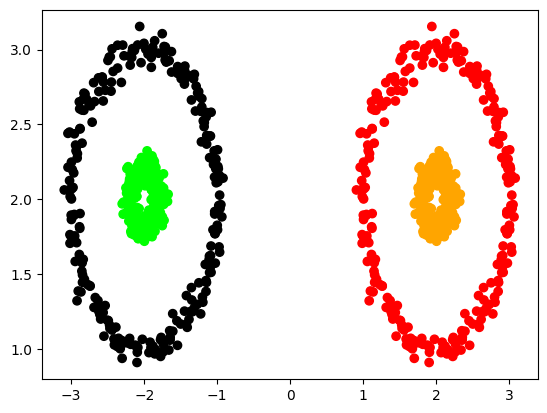

In [3]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

# Generate 5 pairs of data with specified center positions and unique IDs for each ring
centers_coordinates = [(2, 2), (-2, 2)]  # Specify center positions for each pair

rings = Rings()

X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=500, factor=0.2, noise=0.05)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors))

In [4]:
K = 4
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=3)

### kMeans

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ACC: 0.70 PUR: 0.70 NMI: 0.65 ARI: 0.49


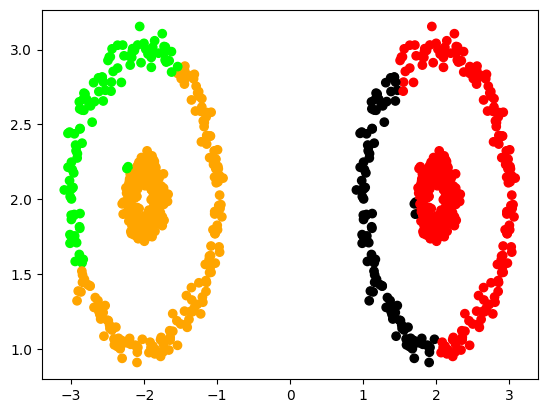

In [5]:
kmeans = KMeans(n_clusters=K).fit(X)
acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=ListedColormap(colors))

### Kernel kMeans

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1000 1-dimensional timeseries
  warnings.warn(


ACC: 0.79 PUR: 0.79 NMI: 0.69 ARI: 0.62


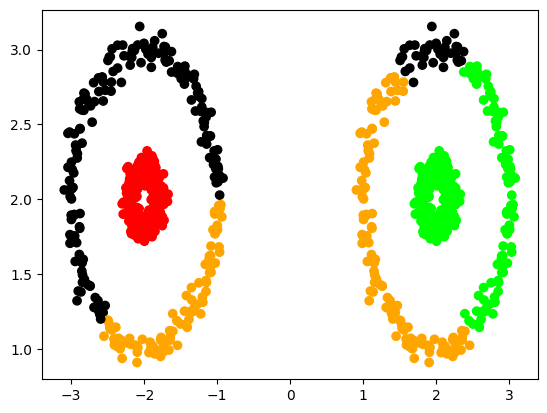

In [6]:
# Should find a way to init the fucking centers!
kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_, cmap=ListedColormap(colors))
plt.show()

### Kernel kMeans++

Executing Kernel k-Means++ Initialization
Iter: 0 Cl L: 633.9007
Iter: 1 Cl L: 621.2508
Iter: 2 Cl L: 608.7922
Iter: 3 Cl L: 591.6318
Iter: 4 Cl L: 563.4764
Iter: 5 Cl L: 525.8201
Finished in Iter: 6 Cl L: 525.7380
Executing Kernel k-Means++ Initialization
Iter: 0 Cl L: 634.4897
Iter: 1 Cl L: 623.1909
Iter: 2 Cl L: 610.7615
Iter: 3 Cl L: 593.8341
Iter: 4 Cl L: 565.0662
Iter: 5 Cl L: 526.7802
Finished in Iter: 6 Cl L: 525.7380
Executing Kernel k-Means++ Initialization
Iter: 0 Cl L: 673.5078
Iter: 1 Cl L: 669.4740
Iter: 2 Cl L: 658.4844
Iter: 3 Cl L: 652.7512
Iter: 4 Cl L: 648.8763
Iter: 5 Cl L: 643.5718
Iter: 6 Cl L: 624.4637
Iter: 7 Cl L: 596.1644
Finished in Iter: 8 Cl L: 595.7062
Executing Kernel k-Means++ Initialization
Iter: 0 Cl L: 635.2508
Iter: 1 Cl L: 626.2946
Iter: 2 Cl L: 615.0349
Iter: 3 Cl L: 601.3929
Iter: 4 Cl L: 575.3945
Iter: 5 Cl L: 533.8897
Finished in Iter: 6 Cl L: 525.7380
Executing Kernel k-Means++ Initialization
Iter: 0 Cl L: 624.7673
Iter: 1 Cl L: 600.6073
Iter: 

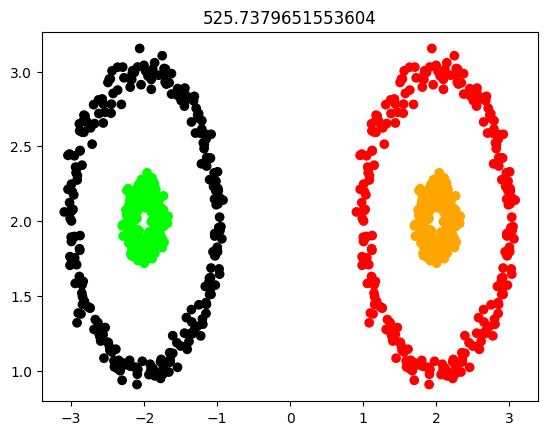

In [7]:
kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=10, init='k-means++')
kernelKMeans.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=kernelKMeans.labels_, cmap=ListedColormap(colors))
plt.title(kernelKMeans.inertia_)
plt.show()

### Global Kernel kMeans

In [8]:
globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix)
globalKernelKMeans.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=globalKernelKMeans.labels_[K], cmap=ListedColormap(colors))
plt.title(globalKernelKMeans.inertia_[K])
plt.show()

Executing Kernel k-Means++ Initialization
Iter: 0 Cl L: 824.4274
Iter: 1 Cl L: 822.2536
Iter: 2 Cl L: 820.4548
Iter: 3 Cl L: 819.0606
Iter: 4 Cl L: 817.8588
Iter: 5 Cl L: 816.4601
Iter: 6 Cl L: 815.1192
Iter: 7 Cl L: 813.5542
Iter: 8 Cl L: 812.0291
Iter: 9 Cl L: 809.1413
Finished in Iter: 10 Cl L: 803.6188
Executing Kernel k-Means++ Initialization
Finished in Iter: 0 Cl L: 730.2010
Executing Kernel k-Means++ Initialization
Iter: 0 Cl L: 823.6232
Iter: 1 Cl L: 822.2118
Iter: 2 Cl L: 820.9535
Iter: 3 Cl L: 819.3192
Iter: 4 Cl L: 817.5838
Iter: 5 Cl L: 815.9471
Iter: 6 Cl L: 814.4102
Iter: 7 Cl L: 812.3447
Iter: 8 Cl L: 809.9473
Iter: 9 Cl L: 805.6497
Finished in Iter: 10 Cl L: 803.6188
Executing Kernel k-Means++ Initialization
Finished in Iter: 0 Cl L: 730.2010
Executing Kernel k-Means++ Initialization
Finished in Iter: 0 Cl L: 730.2010
Executing Kernel k-Means++ Initialization
Iter: 0 Cl L: 750.0469
Iter: 1 Cl L: 729.1038
Iter: 2 Cl L: 723.0280
Iter: 3 Cl L: 704.9677
Finished in Iter: 4